# Rt Live Model

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-x9ez9a_1 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Fetch data and select the state's data

In [2]:
df = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today())#-pd.Timedelta(days=1))
dfunn = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False)#-pd.Timedelta(days=1))
dfsev = get_and_process_covidtracking_data_ilsev(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [3]:
region = "Israel"
model_data = df.loc[region]
model_sev = dfsev.loc[region]
model_unn = dfunn.loc[region]

## Create the model instance and sample

In [4]:
gmsev = GenerativeModel(region, model_sev, buffer_days = 20, delay=2+5, sigma=0.07)
gmsev.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 7178 seconds.


In [5]:
gm = GenerativeModel(region, model_data, delay=2, sigma=0.07)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 10560 seconds.


In [19]:
gmunn = GenerativeModel(region, model_unn, delay=2, sigma=0.07)
gmunn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 15099 seconds.


## Summarize Model Output

In [20]:
result = summarize_inference_data(gm.inference_data)
resultsev = summarize_inference_data(gmsev.inference_data)
resultunn = summarize_inference_data(gmunn.inference_data)

In [21]:
result.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-09-12,1.145334,1.137990,1.006146,1.267990,3093.706963,2570.005987,2412.929653,2719,29784
2020-09-13,1.125447,1.122523,1.004128,1.260640,3183.222994,2621.790564,2477.251395,3175,33876
2020-09-14,1.097931,1.100023,0.959081,1.203572,3270.552920,2677.723071,2744.098840,4805,46282
2020-09-15,1.074609,1.071984,0.953944,1.204612,3350.494699,2738.122858,2600.084440,5539,56307
2020-09-16,1.036621,1.031885,0.917251,1.148031,3417.325106,2802.947649,2282.879884,4574,52958
2020-09-17,0.999888,0.999922,0.874155,1.099815,3468.645946,2871.731658,2476.985396,5385,57462
2020-09-18,0.960008,0.954641,0.850986,1.072688,3500.083305,2943.476917,2651.321996,5340,53235
2020-09-19,0.917332,0.912581,0.802702,1.018873,3506.995539,3016.572210,2410.725634,3810,41773
2020-09-20,0.871825,0.867154,0.752191,0.965520,3487.441910,3089.004058,2899.337127,2579,23511


In [22]:
resultunn.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-09-12,1.084787,1.078405,0.946428,1.196895,5817.661358,4017.862607,2719.0,2719,100000
2020-09-13,1.045416,1.039031,0.911791,1.166338,5956.700688,4231.026748,3175.0,3175,100000
2020-09-14,1.005795,0.999893,0.863234,1.105435,6060.987049,4444.506570,4805.0,4805,100000
2020-09-15,0.963270,0.958078,0.846458,1.067800,6125.686268,4655.340151,5539.0,5539,100000
2020-09-16,0.920845,0.916902,0.802358,1.012987,6145.539667,4860.021866,4574.0,4574,100000
2020-09-17,0.883850,0.879932,0.769678,0.987961,6116.457519,5054.714127,5385.0,5385,100000
2020-09-18,0.841803,0.839201,0.744527,0.954382,6036.480770,5235.363585,5340.0,5340,100000
2020-09-19,0.800269,0.795801,0.687091,0.889823,5909.038431,5397.701633,3810.0,3810,100000
2020-09-20,0.763453,0.758785,0.649153,0.848856,5736.328002,5537.337482,2579.0,2579,100000


In [23]:
resultsev.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-09-11,1.091979,1.084689,0.945692,1.221864,106.840367,65.331950,45.0,45.0,10000
2020-09-12,1.067352,1.063849,0.939515,1.198408,109.350519,67.915413,61.0,61.0,10000
2020-09-13,1.035397,1.031758,0.907315,1.163897,111.353392,70.674412,65.0,65.0,10000
2020-09-14,1.007484,1.000716,0.875608,1.123860,112.856866,73.600583,75.0,75.0,10000
2020-09-15,0.977426,0.967955,0.861521,1.090382,113.791723,76.679085,62.0,62.0,10000
2020-09-16,0.947061,0.947284,0.832563,1.054321,114.104786,79.886174,88.0,88.0,10000
2020-09-17,0.919216,0.920214,0.824176,1.044178,113.780460,83.189768,91.0,91.0,10000
2020-09-18,0.888722,0.885830,0.773307,0.989280,112.791891,86.550316,83.0,83.0,10000
2020-09-19,0.860970,0.860972,0.748246,0.961548,111.159432,89.919990,86.0,86.0,10000


## Plot Model Output

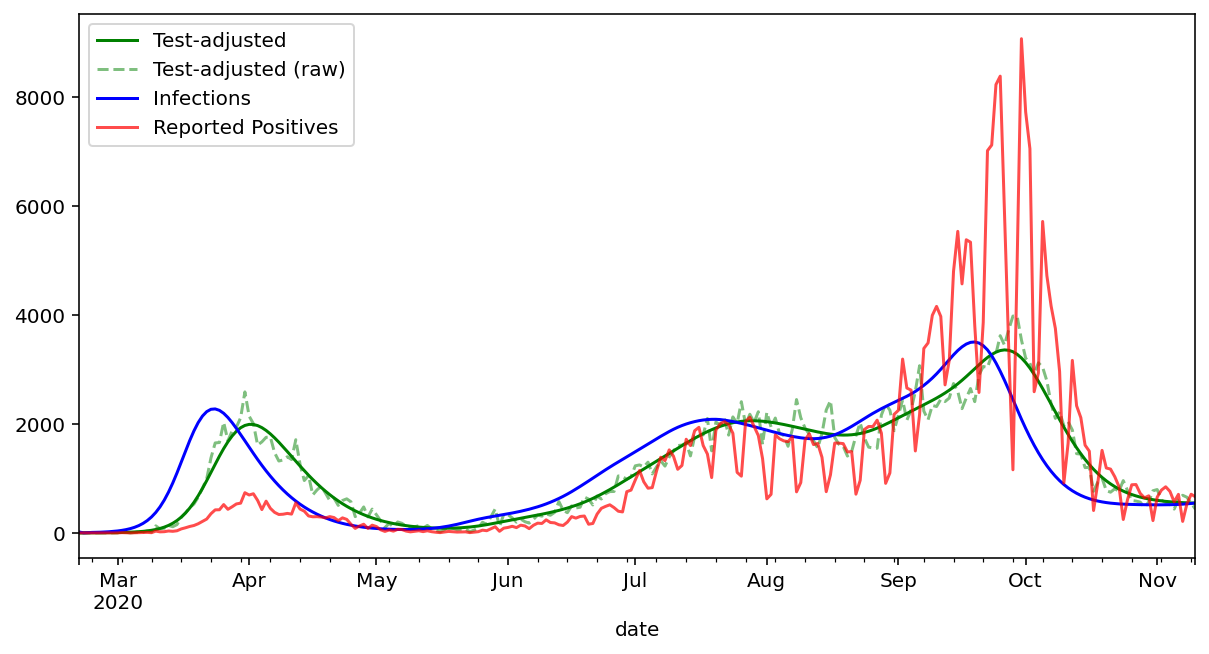

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result.infections.plot(c="b", label="Infections")
gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

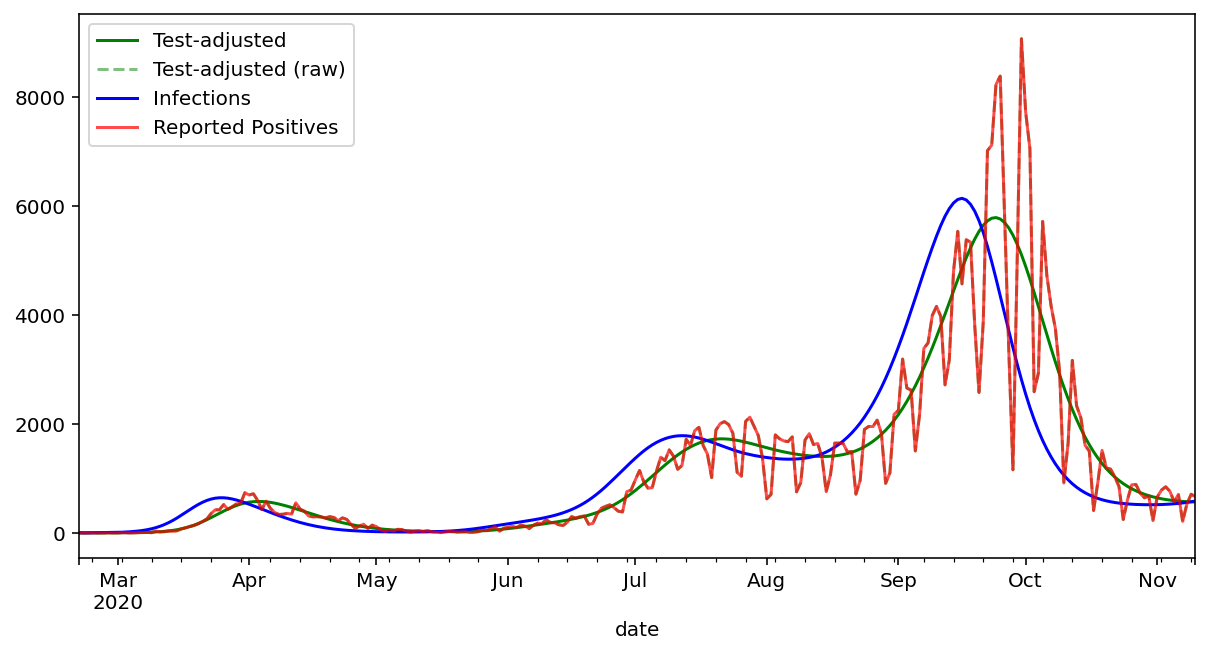

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
resultunn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
resultunn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultunn.infections.plot(c="b", label="Infections")
gmunn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

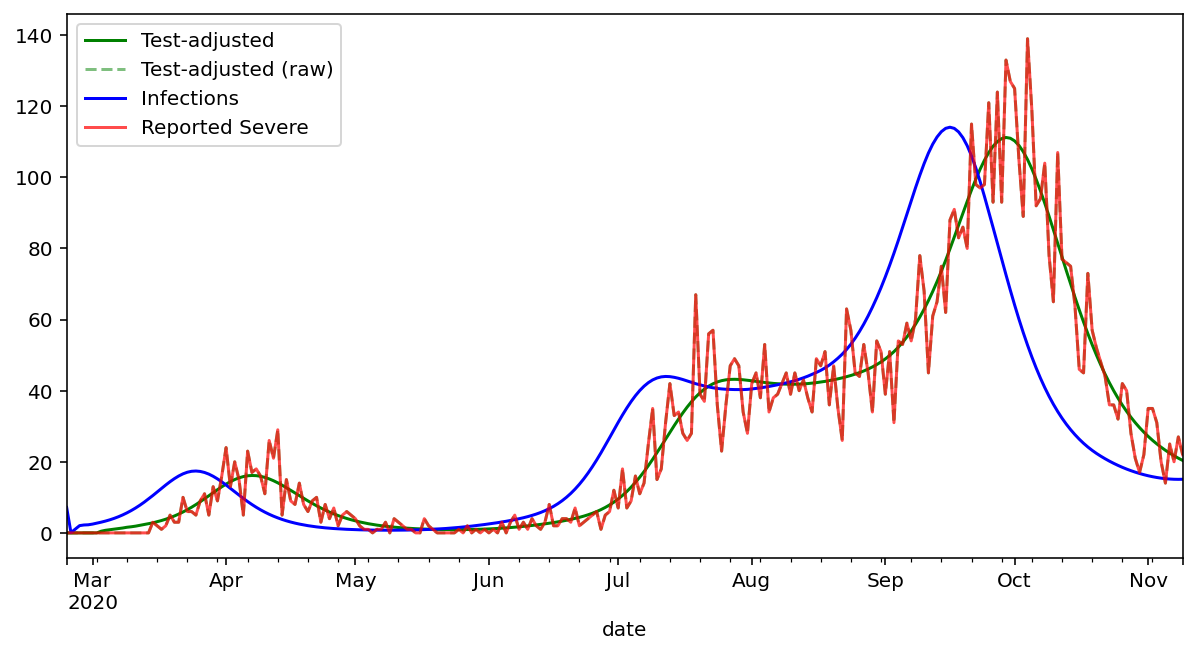

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
resultsev.test_adjusted_positive.plot(c="g", label="Test-adjusted")
resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsev.infections.plot(c="b", label="Infections")
gmsev.observed.positive.plot(c='r', alpha=.7, label="Reported Severe")
fig.set_facecolor('w')
ax.legend();

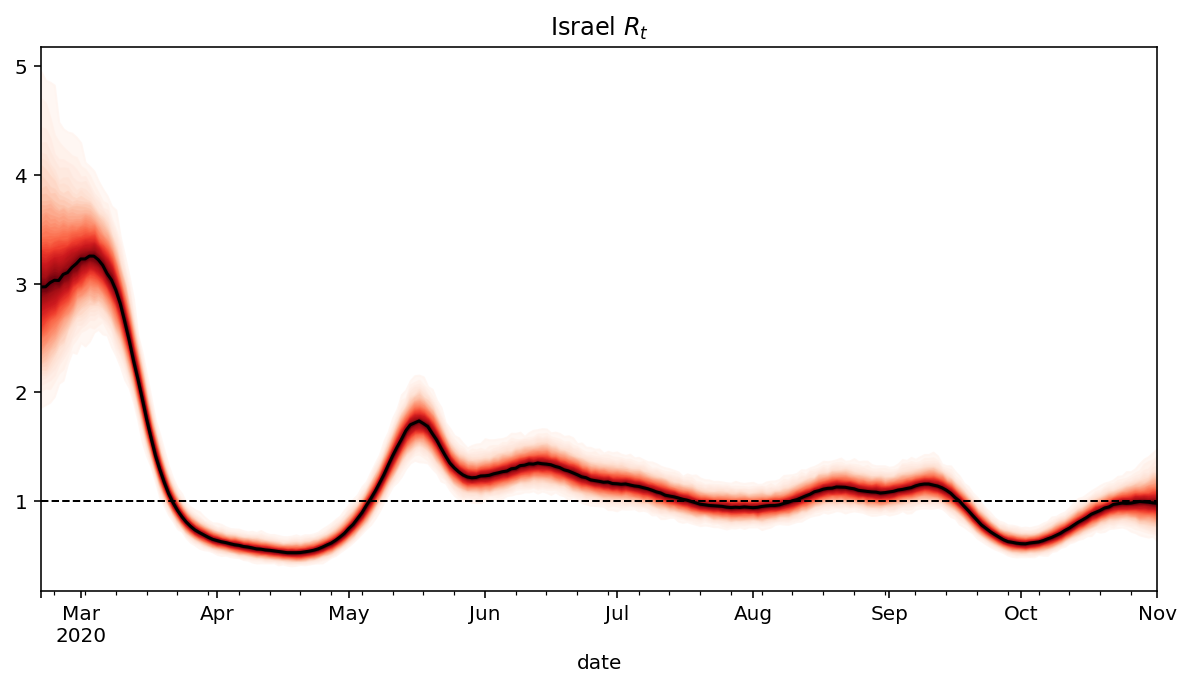

In [27]:
#plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$")
samples = gm.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')

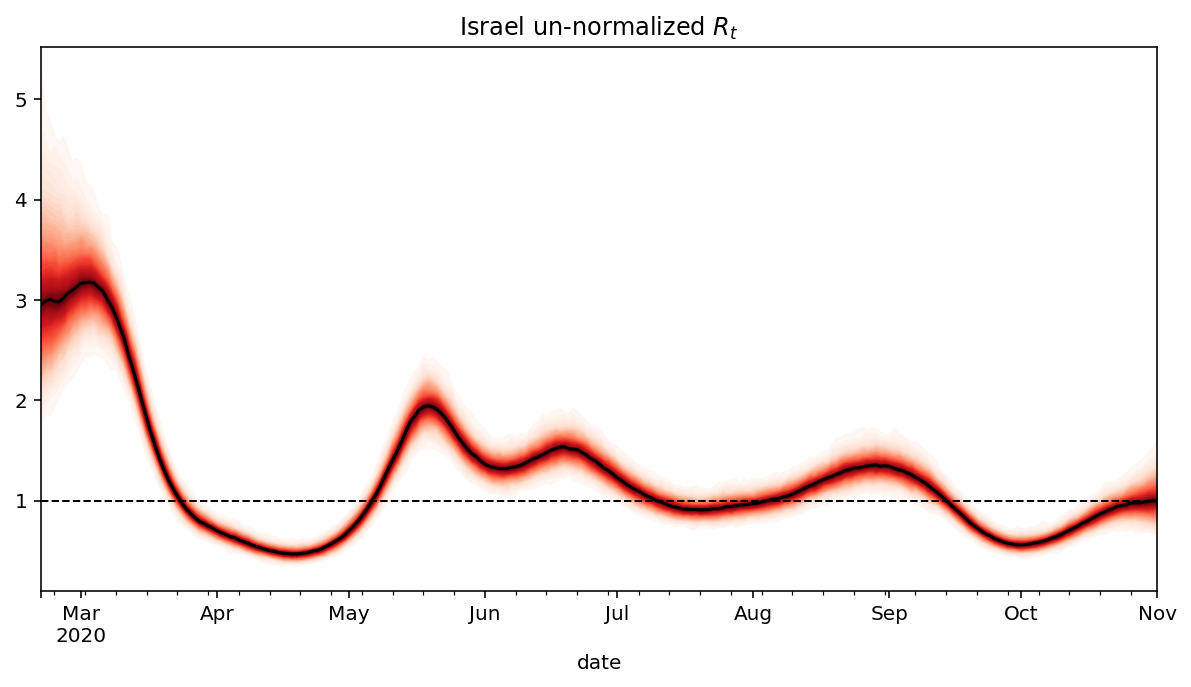

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultunn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')
fig.savefig("Israel_unnorm_Rt_est.svg")

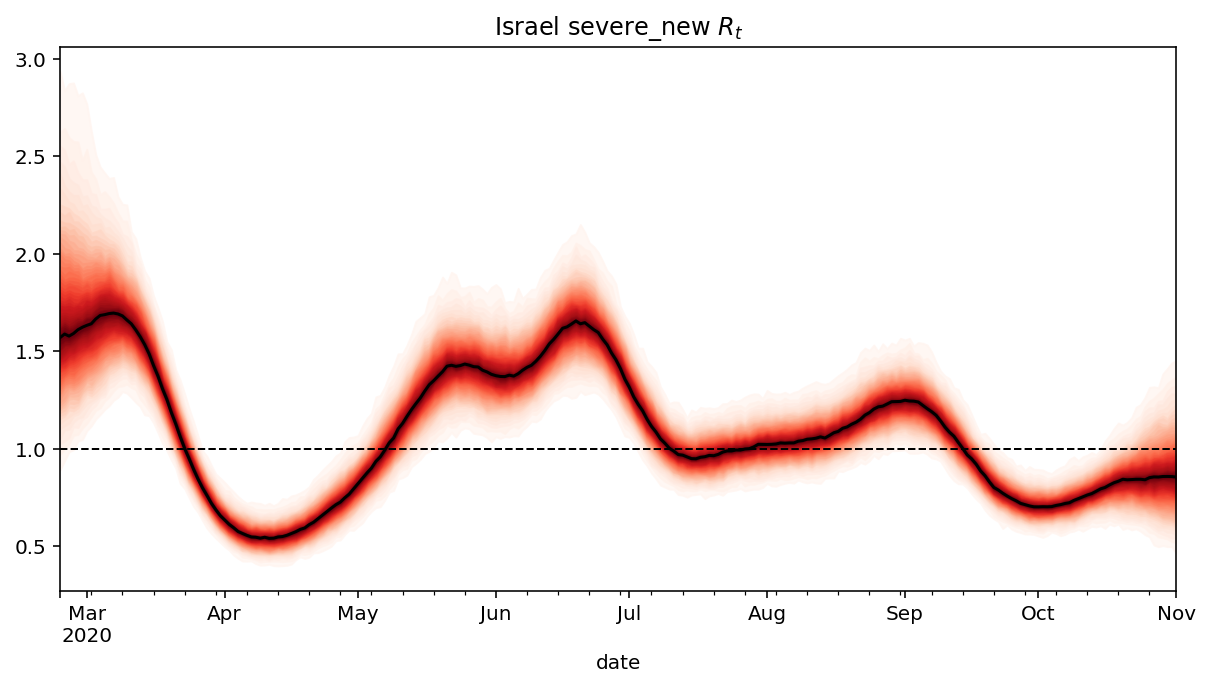

In [29]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new $R_t$")
samples = gmsev.trace['r_t']
x=resultsev.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsev["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

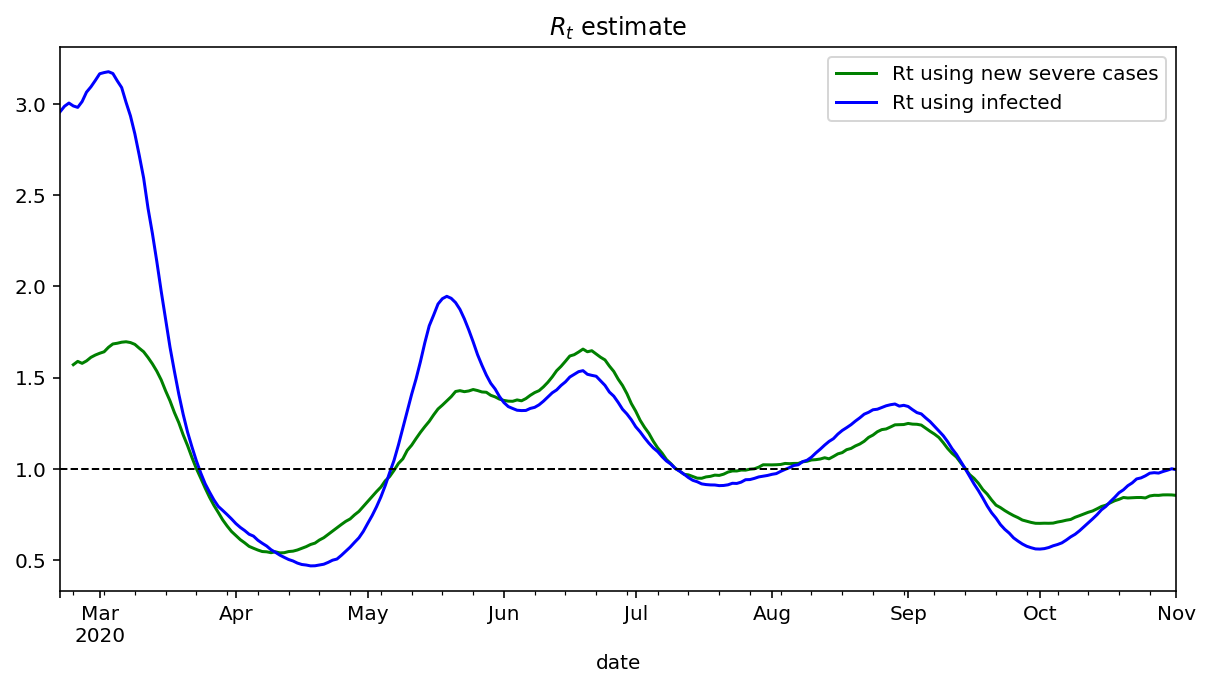

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"$R_t$ estimate")
resultsev["median"].plot(c="g", ls='-', label="Rt using new severe cases")
resultunn["median"].plot(c="b", ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
ax.legend()

In [31]:
resultunn.to_csv("results_unnormalized_out.csv")